## Enhanced featrue engineer model

This model will add engineered features for the original question, in addition to the lemmatized question.

Engineered two different types of features,

1. n_gram similarity between each pair of questions
2. min/max/avg distance between words in a single question. Currently using the following metrics,
  * euclidean
  * cosine
  * city block or manhattan
  
**Pipeline**
1. Stack questions
2. Clean questions - now lower cases all words to better lemmatize proper nouns
3. UNION
    1. n_gram similarity
    2. min/max/avg distance
4. Lemmatize questions
5. UNION
    1. n_gram similarity
    2. min/max/avg distances
6. UNION together both sets of features
7. XGBClassifier

In [1]:
# data manipulation
import utils
import pandas as pd
import numpy as np

# modeling
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import cross_validate, StratifiedKFold

from xgboost import XGBClassifier

In [2]:
X_train = utils.load('X_train')
y_train = utils.load('y_train')
model_name = 'xgb_hypertuned_dup_features'

In [3]:
# text transformation pipes
clean_text = Pipeline(
    [
        ('stack', FunctionTransformer(utils.stack_questions, validate=False)),
        ('clean', FunctionTransformer(utils.clean_questions, validate=False))

    ]
)

lemma_text = Pipeline(
    [
        ('lemma', FunctionTransformer(utils.apply_lemma, validate=False))
    ]
)

# feature engineering pipes
single_question_pipe = Pipeline(
    [
        ('dist', FunctionTransformer(utils.add_min_max_avg_distance_features, validate=False)),
        ('unstack', FunctionTransformer(utils.unstack_questions, validate=False))
    ]
)

pair_question_pipe = Pipeline(
    [
        ('ngram_sim', FunctionTransformer(utils.calc_ngram_similarity, kw_args={'n_grams':[1, 2, 3]}, validate=False))
    ]
)

# build features on the cleaned text only
clean_text_features = Pipeline(
    [
        ('clean', clean_text),
        ('feats', FeatureUnion(
            [
                ('pair', pair_question_pipe),
                ('single', single_question_pipe)
            ]
        ))
    ]
)

# build features on the cleanned and lemmatized text features
lemma_text_features = Pipeline(
    [
        ('clean', clean_text),
        ('lemma', lemma_text),
        ('feats', FeatureUnion(
            [
                ('pair', pair_question_pipe),
                ('single', single_question_pipe)
            ]
        ))
    ]
)

# pre-process pipe
feature_transformation = Pipeline(
    [
        ('feats', FeatureUnion(
            [
                ('clean_text_features', clean_text_features),
                ('lemma_text_features', lemma_text_features)
            ]
        ))
    ]
)


In [38]:
%%time
try:
    X_train_transform = utils.load('X_train_transform')
except:
    X_train_transform = feature_transformation.transform(X_train) ## this takes a really long time
    utils.save(X_train_transform, 'X_train_transform')

CPU times: user 63.7 ms, sys: 235 ms, total: 298 ms
Wall time: 619 ms


In [39]:
X_train_transform.shape

(303199, 42)

In [40]:
first_question_dist_features = X_train_transform[:, :21]
first_question_dist_features.shape

(303199, 21)

In [41]:
second_question_dist_features = X_train_transform[:, 21:]
second_question_dist_features.shape

(303199, 21)

In [42]:
X_train_transform = np.vstack([X_train_transform, 
                               np.hstack([second_question_dist_features, first_question_dist_features])])

X_train_transform.shape

(606398, 42)

In [9]:
y_train = np.hstack([y_train, y_train])
y_train.shape

(606398,)

In [44]:
search_cv = utils.load('tuned_models/xgb_hypertune_0.884651')

In [45]:
search_cv.best_params_

{'gamma': 0.1497064614824524,
 'learning_rate': 0.22505353861797678,
 'max_depth': 7,
 'n_estimators': 734,
 'reg_lambda': 0.7046261327596275}

In [46]:
xgb_params = search_cv.best_params_
xgb_params['n_jobs'] = 4
xgb_params['random_state'] = 42
xgb_params

{'gamma': 0.1497064614824524,
 'learning_rate': 0.22505353861797678,
 'max_depth': 7,
 'n_estimators': 734,
 'reg_lambda': 0.7046261327596275,
 'n_jobs': 4,
 'random_state': 42}

In [13]:
xgb = XGBClassifier(**xgb_params)

In [26]:
%%time
skf = StratifiedKFold(n_splits=3, random_state=42)
cv = cross_validate(xgb, 
               X_train_transform, 
               y_train, 
               cv=skf, 
               n_jobs=3, 
               scoring=('accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'neg_log_loss'))

CPU times: user 236 ms, sys: 160 ms, total: 396 ms
Wall time: 26min 20s


In [27]:
results_df = utils.load('results')

results_df = results_df.drop(index=model_name, errors='ignore')
results_df = results_df.append(utils.log_scores(cv, model_name))
results_df.sort_values('avg_auc', ascending=False)

,avg_accuracy,std_accuracy,avg_precision,std_precision,avg_recall,std_recall,avg_f1,std_f1,avg_auc,std_auc,avg_log_loss,std_log_loss
xgb_hypertuned,0.800791,0.001007,0.732020,0.001803,0.726379,0.001644,0.729187,0.001261,0.884651,0.000787,0.406161,0.001380
xgb_hypertuned_dup_features,0.788520,0.007471,0.714135,0.010980,0.712489,0.008232,0.713308,0.009598,0.873554,0.006916,0.420222,0.010238
rf_feat_eng_model_lemma_clean,0.783667,0.002260,0.708853,0.003681,0.702725,0.001666,0.705774,0.002658,0.868202,0.001148,0.436197,0.000640
ensemble_rf_xgb,0.779000,0.002740,0.697794,0.004357,0.708157,0.001912,0.702935,0.003148,0.863334,0.001438,0.441784,0.001107
xgb_feat_eng_incl_nums,0.767110,0.001576,0.682213,0.002621,0.701238,0.002695,0.691590,0.001899,0.851957,0.001192,0.450099,0.001675
feat_eng_model_lemma_clean,0.763927,0.002404,0.676166,0.003904,0.692113,0.001128,0.684044,0.002549,0.846923,0.001643,0.456929,0.001410
feat_eng_model_lemma_fix,0.744356,0.002107,0.664513,0.004333,0.621357,0.000901,0.642201,0.001609,0.822197,0.001710,0.488131,0.001342
feat_eng_model,0.743614,0.002021,0.664102,0.003502,0.618400,0.001553,0.640434,0.002281,0.821070,0.001428,0.489465,0.001141
ensemble_rf_xgb_cos_sim,0.738700,0.007359,0.661290,0.010948,0.612827,0.009669,0.636128,0.009994,0.819987,0.005193,0.493703,0.003901
lstm_Bidrectional,0.752968,0.000000,0.702084,0.000000,0.574900,0.000000,0.632158,0.000000,0.803540,0.000000,8.532243,0.000000


In [28]:
utils.save(results_df, 'results')

## Fit entire training data

Validation AUC is 0.88. We will now fit on the entire train data to then score against the test data.

In [7]:
xgb_params["n_jobs"] = 3
xgb = XGBClassifier(**xgb_params)
xgb

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1497064614824524,
       learning_rate=0.22505353861797678, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=734, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=0.7046261327596275, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [21]:
%%time
xgb.fit(X_train_transform, y_train)
utils.save(xgb, 'xgb_ht_best_model_question_swapped')

CPU times: user 1h 5min 38s, sys: 352 ms, total: 1h 5min 38s
Wall time: 9min 25s


In [2]:
xgb = utils.load('xgb_ht_best_model_question_swapped')

## Score the test data set

In [3]:
X_test = utils.load('X_test')
y_test = utils.load('y_test')

In [4]:
%%time
try:
    X_test_transform = utils.load('X_test_transform')
except:
    X_test_transform = feature_transformation.transform(X_test) ## this takes a really long time
    utils.save(X_test_transform, 'X_test_transform')
# X_test_transform = feature_transformation.transform(X_test)

CPU times: user 17.2 ms, sys: 50.2 ms, total: 67.5 ms
Wall time: 115 ms


In [5]:
X_test_transform.shape

(101067, 42)

In [6]:
first_question_dist_features = X_test_transform[:, :21]
first_question_dist_features.shape

second_question_dist_features = X_test_transform[:, 21:]
second_question_dist_features.shape

X_test_transform = np.vstack([X_test_transform, 
                               np.hstack([second_question_dist_features, first_question_dist_features])])

X_test_transform.shape

(202134, 42)

In [7]:
y_test = np.hstack([y_test, y_test])
y_test.shape

(202134,)

In [8]:
test_probs = xgb.predict_proba(X_test_transform)[:, 1]

In [9]:
from sklearn import metrics

In [10]:
metrics.roc_auc_score(y_test, test_probs)

0.8848022083659819

In [11]:
metrics.log_loss(y_test, test_probs)

0.40297918872871447

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'png'

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

''

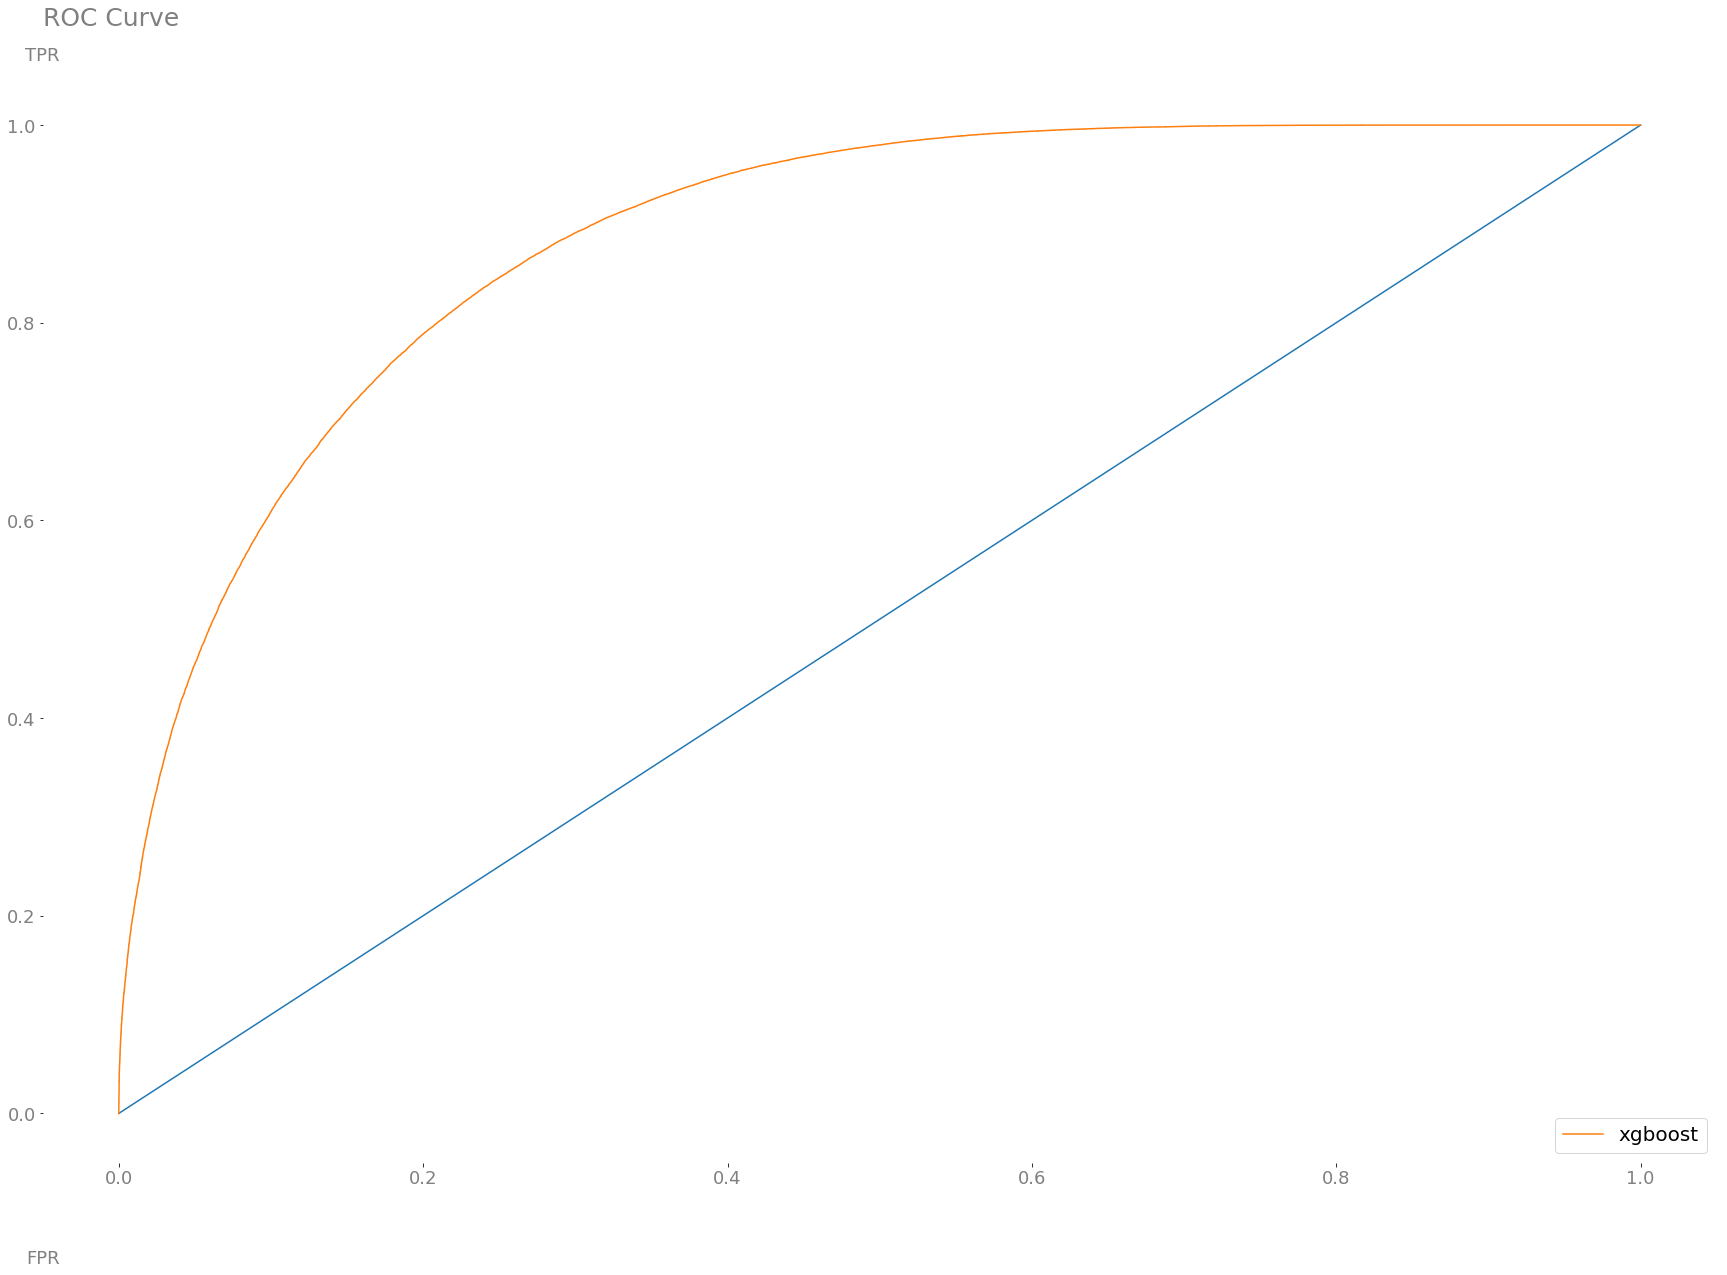

In [42]:
fpr_gb, tpr_gb, _ = metrics.roc_curve(y_test, test_probs)

fig, ax = plt.subplots(figsize=(30,20))

# Plotting our Baseline..
ax.plot([0,1],[0,1])
ax.plot(fpr_gb, tpr_gb, label='xgboost')
# plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.legend(fontsize=20, loc='lower right')

title_style = {
    'position':(0,1.05),
    'horizontalalignment': 'left'
}

# set the x labels
ax.set_xlabel('FPR', fontsize=18, color = 'gray')
ax.xaxis.set_label_coords(0, -0.08)

# set the y labels
ax.set_ylabel('TPR', fontsize=18, color = 'gray', rotation=0)
ax.yaxis.set_label_coords(0, 1.01)

# set title
ax.set_title('ROC Curve', fontsize=25, color='gray', loc='left', pad=50)

# remove the borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# set x/y tick labels
for label in (ax.get_yticklabels() + ax.get_xticklabels()):
    label.set_fontsize(18)
    label.set_color('gray')

# ax.annotate('AUC', xy=(0.4, 0.6), xytext=(0.5, 0.8),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
# plt.title('ROC Curve', fontsize=25, color='gray')
;

''

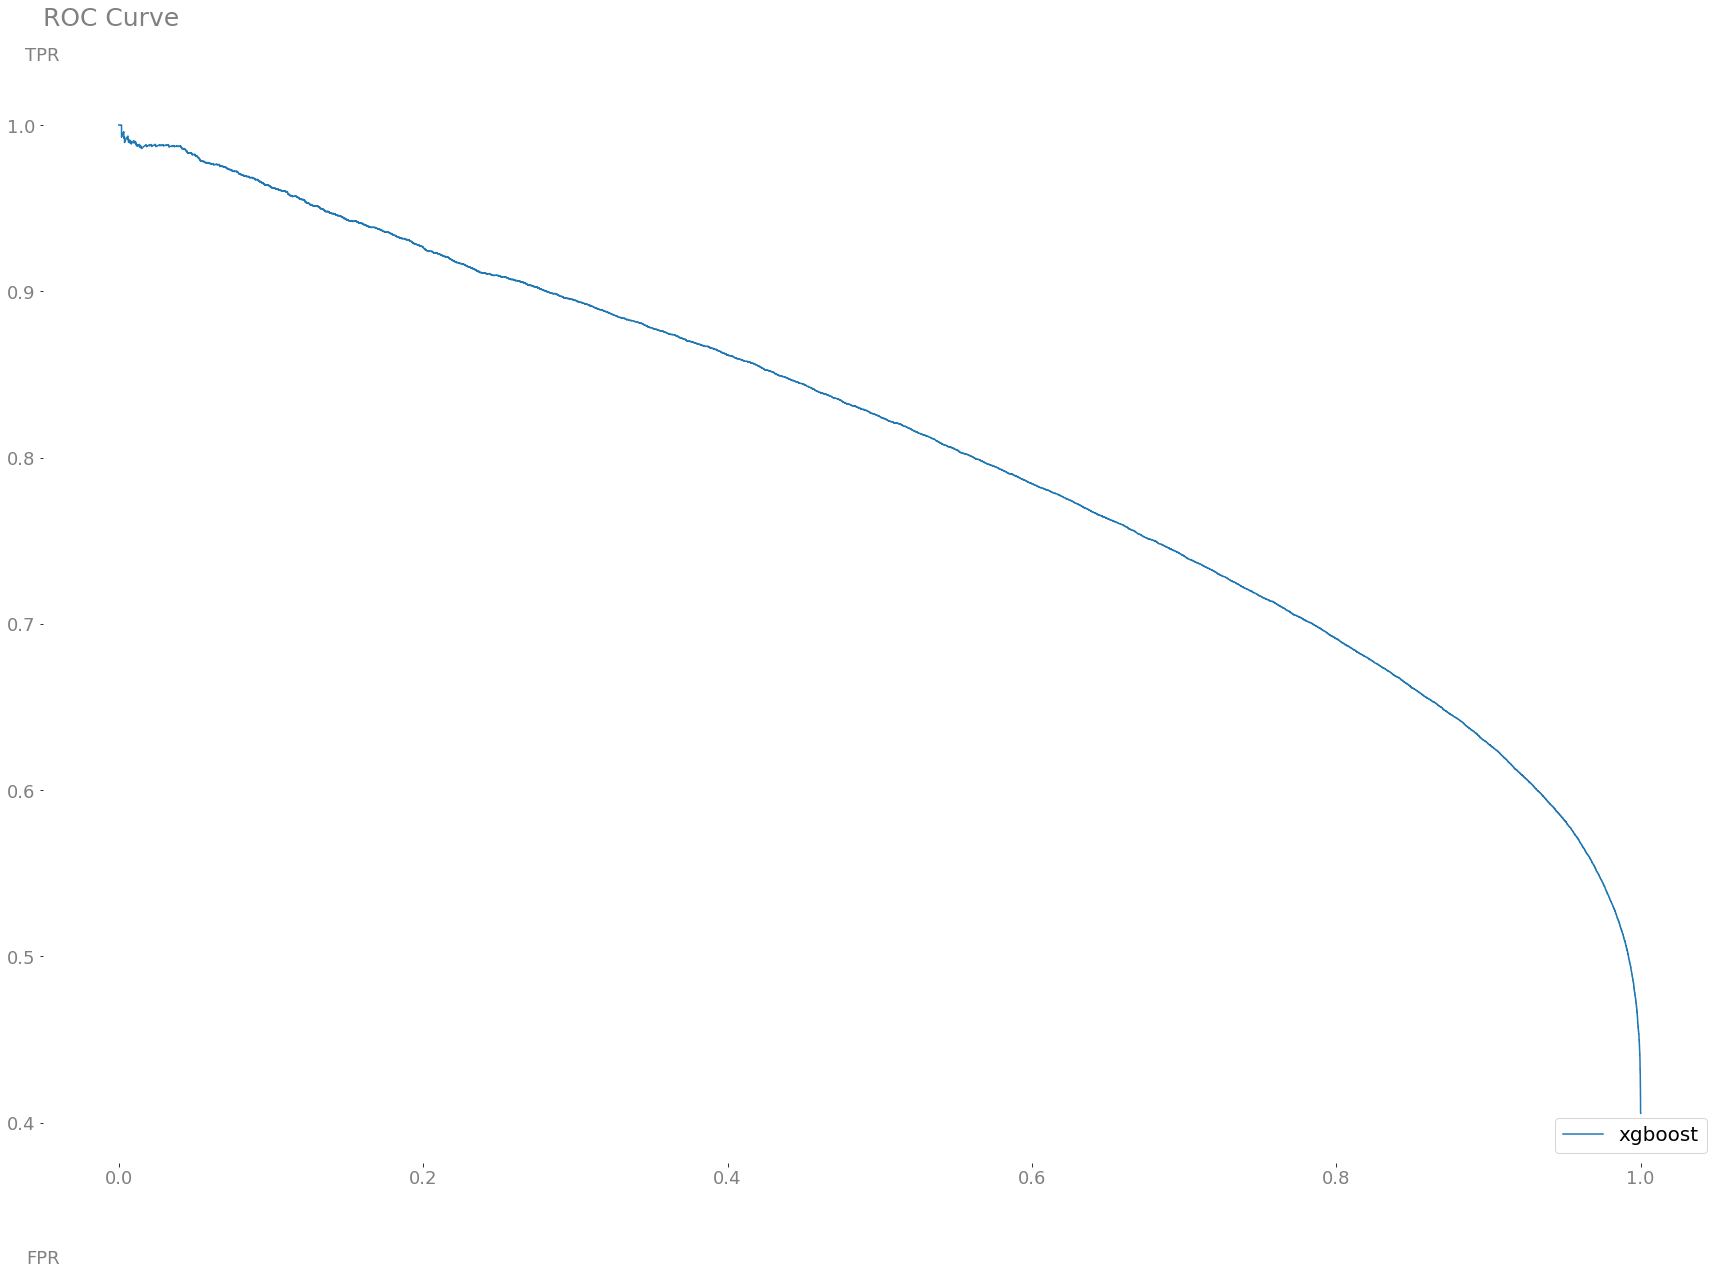

In [46]:
prec, recall, _ = metrics.precision_recall_curve(y_test, test_probs)

fig, ax = plt.subplots(figsize=(30,20))

# Plotting our Baseline..
# ax.plot([0,1],[0,1])
ax.plot(recall, prec, label='xgboost')
# plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.legend(fontsize=20, loc='lower right')

title_style = {
    'position':(0,1.05),
    'horizontalalignment': 'left'
}

# set the x labels
ax.set_xlabel('FPR', fontsize=18, color = 'gray')
ax.xaxis.set_label_coords(0, -0.08)

# set the y labels
ax.set_ylabel('TPR', fontsize=18, color = 'gray', rotation=0)
ax.yaxis.set_label_coords(0, 1.01)

# set title
ax.set_title('ROC Curve', fontsize=25, color='gray', loc='left', pad=50)

# remove the borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# set x/y tick labels
for label in (ax.get_yticklabels() + ax.get_xticklabels()):
    label.set_fontsize(18)
    label.set_color('gray')

# ax.annotate('AUC', xy=(0.4, 0.6), xytext=(0.5, 0.8),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
# plt.title('ROC Curve', fontsize=25, color='gray')
;

In [30]:
import seaborn as sns

def conf_matrix(actual, predicted):
    cm = metrics.confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");
    plt.savefig('../docs/img/conf_matrix.png', dpi=300)

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = {'Accuracy:': accuracy, 
                  'Precision:': precision, 
                  'Recall:': recall, 
                  'F!:': f1}
    
    return cm_results

{'Accuracy:': 0.799, 'Precision:': 0.728, 'Recall:': 0.727, 'F!:': 0.727}

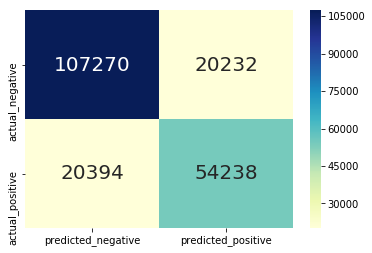

In [31]:
test_score = (test_probs >= 0.5).astype(int)
conf_matrix(y_test, test_score)

In [35]:
X_train = utils.load('X_train')

In [36]:
X_train[X_train.id == 180]

,id,question1,question2
180,180,How do you get deleted Instagram chats?,How can I view deleted Instagram dms?


In [48]:
train_probs = xgb.predict_proba(X_train_transform)[:, 1]

In [53]:
utils.save(train_probs, 'train_probs')

## Summary

The test score is very similar to the validation score, and thus the model should genearlize well. Next, the full data set will be trained for the Slack bot app.

In [33]:
X_full_transform = np.vstack([X_train_transform, X_test_transform])
y_full_transform = np.hstack([y_train, y_test])
print('X_full shape:', X_full_transform.shape)
print('y_full shape:', y_full_transform.shape)

X_full shape: (808532, 42)
y_full shape: (808532,)


In [34]:
%%time
xgb.fit(X_full_transform, y_full_transform)

CPU times: user 1h 27min 24s, sys: 536 ms, total: 1h 27min 25s
Wall time: 12min 39s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1497064614824524,
       learning_rate=0.22505353861797678, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=734, n_jobs=7,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=0.7046261327596275, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

In [35]:
utils.save(xgb, 'xgb_FINAL_model_question_swapped')

In [37]:
utils.save(feature_transformation, 'feature_pipe')
utils.save(X_full_transform, 'X_full_transform')
utils.save(y_full_transform, 'y_full_transform')
utils.save(X_test_transform, 'X_test_transform')